<a href="https://colab.research.google.com/github/leticiafcarvalho/recomendacaoPorImagens/blob/main/recomendacaoPorImagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552452 sha256=6acc076f833708726032bfdd1c13dc7a0fed9ac9a1037c0b97860d8a4371a05a
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [17]:
# Etapa 1: Configuração do ambiente
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from annoy import AnnoyIndex
import tensorflow_hub as hub
from google.colab import drive

# Montar o Google Drive
drive.mount('/content/drive')

# Defina o caminho das imagens e da imagem de teste
IMAGE_DIR = '/content/drive/MyDrive/Imagens/'  # Atualize com o caminho correto
TEST_IMAGE_PATH = '/content/drive/MyDrive/relogio.jpg'  # Atualize com o caminho da imagem de teste
BASEWIDTH = 224  # Dimensão de redimensionamento para as imagens

# Etapa 2: Carregar o modelo de extração de características (TFHub)
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
model = hub.load(MODEL_URL)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np

def preprocess_image(image_path):
    """Pré-processa uma imagem para o modelo."""
    TARGET_SIZE = (224, 224)  # Dimensão esperada pelo modelo (224x224)
    img = Image.open(image_path).convert('RGB')  # Garante que a imagem está em RGB
    img = img.resize(TARGET_SIZE, Image.Resampling.LANCZOS)  # Redimensiona diretamente para 224x224
    img = img_to_array(img) / 255.0  # Normaliza os valores para [0, 1]
    img = np.expand_dims(img, axis=0)  # Adiciona uma dimensão para o batch
    return img

In [23]:
# Etapa 3: Extrair características e construir o índice Annoy
file_index_to_file_name = {}
index = AnnoyIndex(1280, 'angular')  # 1280 é o tamanho do vetor de características do modelo

# Listar imagens no diretório e construir o índice
for idx, file_name in enumerate(os.listdir(IMAGE_DIR)):
    file_path = os.path.join(IMAGE_DIR, file_name)
    if file_path.endswith(('.jpg', '.jpeg', '.png')):  # Verificar se é uma imagem válida
        img = preprocess_image(file_path)
        feature_vector = model(img).numpy()[0]  # Extrair características
        index.add_item(idx, feature_vector)  # Adicionar ao índice
        file_index_to_file_name[idx] = file_name

index.build(10)  # Construir o índice com 10 árvores
print("Índice Annoy criado!")

Índice Annoy criado!


In [24]:
# Etapa 5: Testar com uma imagem
def find_similar_images(test_img_path, top_k=4):
    """Encontrar imagens mais semelhantes à imagem de teste."""
    test_img = preprocess_image(test_img_path)
    test_vector = model(test_img)[0].numpy()
    nearest_neighbors = index.get_nns_by_vector(test_vector, n=top_k)

    plt.figure(figsize=(15, 5))

    # Exibir imagem de teste
    img = Image.open(test_img_path)
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(img)
    plt.title("Imagem de Teste")
    plt.axis('off')

    # Exibir imagens semelhantes
    for i, neighbor_idx in enumerate(nearest_neighbors):
        similar_img_path = os.path.join(IMAGE_DIR, file_index_to_file_name[neighbor_idx])
        img = Image.open(similar_img_path)
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(img)
        plt.title(f"Similar {i+1}")
        plt.axis('off')
    plt.show()

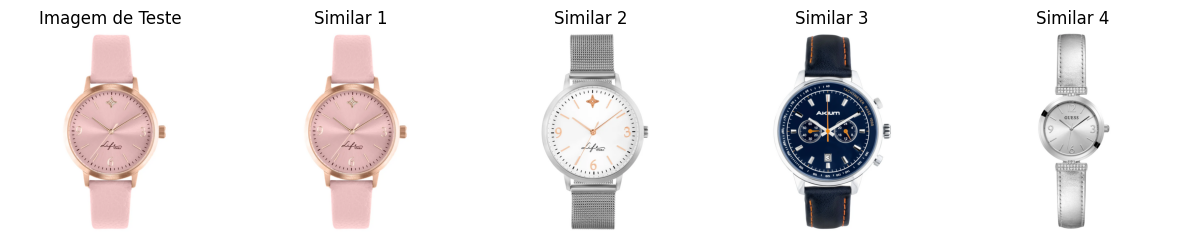

In [25]:
# Teste com uma imagem
TEST_IMAGE_PATH = '/content/drive/MyDrive/relogio.jpg'  # Atualize com a imagem de teste
find_similar_images(TEST_IMAGE_PATH)